In [9]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#Set pandas options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format


In [10]:
def main(city, province, step, lags):
    national_fire = pd.read_csv('data\\wildfire\\fire_area\\national_clean.csv', parse_dates=['date'])
    national_smoke = pd.read_csv('data\\smoke\\national\\national_smoke.csv', parse_dates=['date'])
    city_smoke = national_smoke[national_smoke['city'] == city].drop(columns='city')

    national_fire = pd.merge(national_fire, city_smoke, on='date', how='outer').dropna()

    aggs = {}
    for i in national_fire.iloc[:, 1:-1].columns:
        aggs[i] = 'sum'
    aggs['mean_pm25'] = 'mean'

    national_fire = national_fire.groupby('date').agg(aggs)

    #Create the Timestep
    national_fire = national_fire.resample(step).agg(aggs)

    # Create lags for the training set
    lagged_dfs = {}
    national_fire = national_fire

    for col in national_fire.columns:
        if col != 'mean_pm25':
            for lag in lags:
                col_lag = national_fire[col].shift(lag, freq=step)
                lagged_dfs[f'{col}_lag_{lag}'] = col_lag

    # Concatenate lagged columns
    lagged_dfs = pd.DataFrame(lagged_dfs)
    national_fire = pd.concat([national_fire, lagged_dfs], axis=1)

    national_fire.loc[:, national_fire.columns != 'mean_pm25'] = national_fire.loc[:, national_fire.columns != 'mean_pm25'].fillna(0)
    national_fire = national_fire.reset_index()
    national_fire = national_fire.dropna()

    #Take only the fire season
    national_fire = national_fire[national_fire['date'].dt.month.isin(range(4,10))]

    # Create Seasonal Fixed Effects for Training Data
    national_fire['month'] = national_fire['date'].dt.month_name()
    month_dummies = pd.get_dummies(national_fire['month'], dtype='float')
    national_fire = pd.concat([month_dummies, national_fire], axis=1)
    national_fire = national_fire.drop(columns={'month'})

    #Run Lasso
    national_fire = national_fire.set_index('date')
    X = national_fire.loc[:, national_fire.columns != 'mean_pm25']
    y = national_fire['mean_pm25']

    features = X.columns

    alpha_values = [0.01, 0.1, 0.5, 1, 10, 100, 1000, 5000, 10000, 25000, 50000, 75000, 100000, 500000, 1000000]
    param_grid = {'alpha': alpha_values}
    tscv = TimeSeriesSplit(n_splits = 5)
    grid_search = GridSearchCV(Lasso(), param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X,y)

    best_alpha = grid_search.best_params_['alpha']
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X,y)

    coef = lasso.coef_
    ind_var = np.array(features)[coef != 0]
    lasso_df = pd.DataFrame({'IV':ind_var, 'Coefficient':coef[coef != 0]})
    
    #Run OLS
    ols_formula = f'mean_pm25 ~ April + May + June + July + August + September + {province}_size_ha'
    for iv in ind_var:
        ols_formula = ols_formula + ' + ' + str(iv)
    OLS = ols(formula=ols_formula, data=national_fire)
    model = OLS.fit(cov_type='HC1')
    
    return model

In [11]:
def ols_summary(time_step, lags):
    cities = {
            'Whitehorse':'yt',
            'Yellowknife':'nt',
            'Vancouver':'bc',
            'Calgary':'ab',
            'Saskatoon':'sk',
            'Winnipeg':'mb',
            'Gatineau':'qc', 
            'Toronto':'on', 
            'Halifax':'ns', 
            'St Johns':'nl',
            'Moncton':'nb'
            }

    counter = 0

    for city, province in cities.items():
        result = main(city, province, time_step, lags=lags)
        r2 = result.rsquared
        r2_adj = result.rsquared_adj
        coefficients = result.params
        standard_errors = result.bse
        t_values = result.tvalues
        p_values = result.pvalues
        skew = result.resid.skew()
        aic = result.aic
        bic = result.bic
        dw = sm.stats.stattools.durbin_watson(result.resid)
        if counter == 0:
            ols_summary = pd.DataFrame({
                'Coefficient': coefficients,
                'Standard Error': standard_errors,
                'T-value': t_values,
                'P-value': p_values,
                'R Squared': r2,
                'R Squared Adjusted': r2_adj,
                'City': city
            })
        else:
            ols_summary = pd.concat([ols_summary,pd.DataFrame({
            'Coefficient': coefficients,
            'Standard Error': standard_errors,
            'T-value': t_values,
            'P-value': p_values,
            'R Squared': r2,
            'R Squared Adjusted': r2_adj,
            'Skew' : skew,
            'AIC' : aic,
            'BIC' : bic,
            'Durbin-Watson' : dw,
            'City': city
            })])
        counter += 1
        
    ols_summary = ols_summary.reset_index().rename(columns={'index':'Independent Variables'})

    return ols_summary

In [12]:
time_steps = range(1, 30 + 1)
step_list = []
r2_adj_list = []

for step in time_steps:
    df = ols_summary(f'{step}D', lags=range(1,(30//step)+1))
    mean_r2 = df.groupby('City').agg({'R Squared Adjusted':'mean'}).sort_values(by='R Squared Adjusted', ascending=False).mean()[0]
    step_list.append(step)
    r2_adj_list.append(mean_r2)

# Create DataFrame from lists
df_means = pd.DataFrame({'Step': step_list, 'R2 Adj': r2_adj_list})


c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e+03, tolerance: 4.066e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+03, tolerance: 6.288e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

KeyboardInterrupt: 

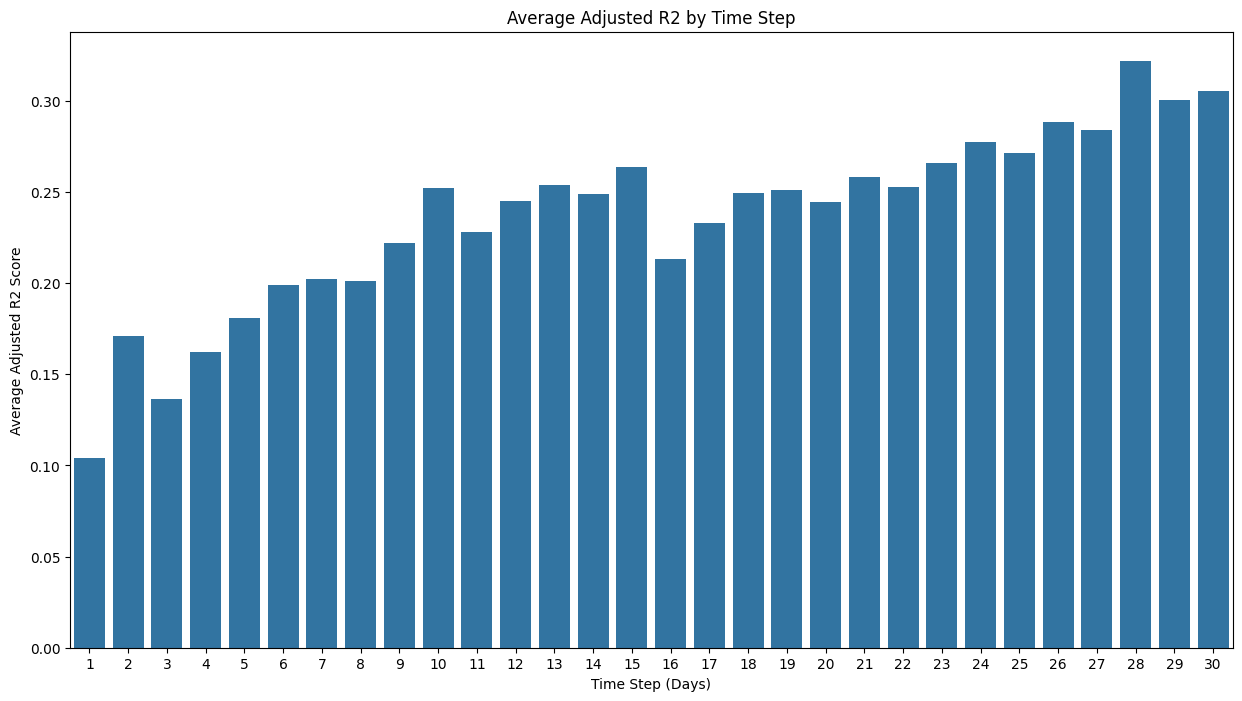

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data=df_means, x='Step', y='R2 Adj')
plt.xlabel('Time Step (Days)')
plt.ylabel('Average Adjusted R2 Score')
plt.title('Average Adjusted R2 by Time Step')
plt.show()

In [ ]:
df = ols_summary(time_step='D', lags=range(1, 30 + 1))
df.to_csv('daily_ols.csv', index=False)
df = ols_summary(time_step='2D', lags=range(1, 15 + 1))
df.to_csv('2_day_ols.csv', index=False)
df = ols_summary(time_step='5D', lags=range(1, 6 + 1))
df.to_csv('5_day_ols.csv', index=False)
df = ols_summary(time_step='15D', lags=range(1, 2 + 1))
df.to_csv('15_day_ols.csv', index=False)
df = ols_summary(time_step='M', lags=range(1, 1 + 1))
df.to_csv('30_day_ols.csv', index=False)

c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+03, tolerance: 4.066e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+03, tolerance: 6.288e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [ ]:
daily = ols_summary(time_step='D', lags=range(1,30 + 1))

c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.005e+03, tolerance: 4.066e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+03, tolerance: 6.288e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\werty\PycharmProjects\LearnPython\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [ ]:
daily[daily['R Squared Adjusted'] == daily['R Squared Adjusted'].max()]

,Independent Variables,Coefficient,Standard Error,T-value,P-value,R Squared,R Squared Adjusted,City,Skew,AIC,BIC,Durbin-Watson
41,Intercept,5.11,0.25,20.81,0.00,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
42,April,0.99,0.30,3.28,0.00,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
43,May,1.44,0.25,5.83,0.00,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
44,June,-0.66,0.39,-1.67,0.09,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
45,July,-0.23,0.46,-0.49,0.63,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
46,August,2.09,0.36,5.80,0.00,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
47,September,1.47,0.34,4.33,0.00,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
48,sk_size_ha,-0.00,0.00,-1.55,0.12,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
49,ab_size_ha_lag_3,0.00,0.00,1.12,0.26,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
50,ab_size_ha_lag_4,0.00,0.00,1.33,0.18,0.27,0.26,Saskatoon,7.80,19573.89,19797.98,1.00
